# TaxPrep Demo Notebook
This notebook demonstrates generating synthetic data and running the local scoring service.

✅ Loaded dataset:


,client_id,turnaround_time_days,error_rate_pct,communication_count,last_feedback_text,true_label
0,1,8,12.0,1,Late delivery,Dissatisfied
1,2,5,2.0,4,Great service,Satisfied
2,3,9,10.0,0,No response,Dissatisfied
3,4,4,1.0,5,Helpful advisor,Satisfied
4,5,2,0.5,6,Quick and accurate filing,Satisfied
5,6,10,15.0,0,Terrible support,Dissatisfied


⚖️ Balancing dataset ...
✅ Balanced dataset with 6 rows (3 per class)
✅ Balanced dataset class distribution:
true_label
Dissatisfied    3
Satisfied       3
Name: count, dtype: int64


/var/folders/5y/5vg713hs19vdmkwwwk8bk_xh0000gp/T/ipykernel_1335/537343669.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, replace=False, random_state=42))


,client_id,turnaround_time_days,error_rate_pct,communication_count,last_feedback_text,true_label
0,1,8,12.0,1,Late delivery,Dissatisfied
1,3,9,10.0,0,No response,Dissatisfied
2,6,10,15.0,0,Terrible support,Dissatisfied
3,2,5,2.0,4,Great service,Satisfied
4,4,4,1.0,5,Helpful advisor,Satisfied
5,5,2,0.5,6,Quick and accurate filing,Satisfied


🚀 Scoring via Azure OpenAI (or heuristic fallback)...
✅ Scoring complete:


,client_id,turnaround_time_days,error_rate_pct,communication_count,last_feedback_text,true_label,label,confidence,top_drivers,pred_label
0,1,8,12.0,1,Late delivery,Dissatisfied,Dissatisfied,0.65,"[{'factor': 'feedback_text', 'impact': 'High'}]",Dissatisfied
1,3,9,10.0,0,No response,Dissatisfied,Dissatisfied,0.65,"[{'factor': 'feedback_text', 'impact': 'High'}]",Dissatisfied
2,6,10,15.0,0,Terrible support,Dissatisfied,Dissatisfied,0.65,"[{'factor': 'feedback_text', 'impact': 'High'}]",Dissatisfied
3,2,5,2.0,4,Great service,Satisfied,Satisfied,0.85,"[{'factor': 'feedback_text', 'impact': 'High'}]",Satisfied
4,4,4,1.0,5,Helpful advisor,Satisfied,Satisfied,0.85,"[{'factor': 'feedback_text', 'impact': 'High'}]",Satisfied
5,5,2,0.5,6,Quick and accurate filing,Satisfied,Satisfied,0.85,"[{'factor': 'feedback_text', 'impact': 'High'}]",Satisfied



📊 Evaluation Metrics:
              precision    recall  f1-score   support

Dissatisfied       1.00      1.00      1.00         3
   Satisfied       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



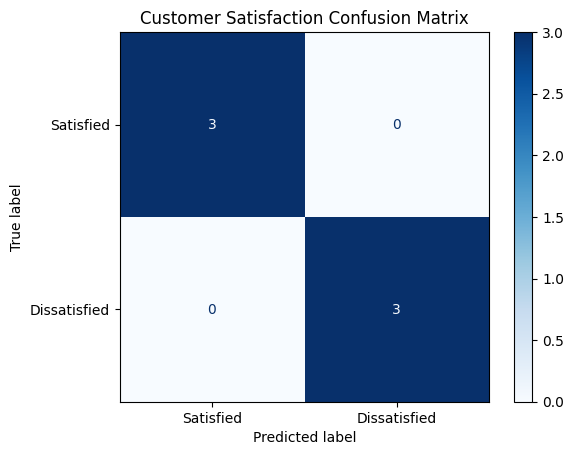


🔍 Sample Predictions:
Client  4: 'Helpful advisor'
 → True: Satisfied     | Pred: Satisfied     | Confidence: 0.85
    Drivers: [{'factor': 'feedback_text', 'impact': 'High'}]
------------------------------------------------------------
Client  3: 'No response'
 → True: Dissatisfied  | Pred: Dissatisfied  | Confidence: 0.65
    Drivers: [{'factor': 'feedback_text', 'impact': 'High'}]
------------------------------------------------------------
Client  1: 'Late delivery'
 → True: Dissatisfied  | Pred: Dissatisfied  | Confidence: 0.65
    Drivers: [{'factor': 'feedback_text', 'impact': 'High'}]
------------------------------------------------------------
Client  6: 'Terrible support'
 → True: Dissatisfied  | Pred: Dissatisfied  | Confidence: 0.65
    Drivers: [{'factor': 'feedback_text', 'impact': 'High'}]
------------------------------------------------------------
Client  2: 'Great service'
 → True: Satisfied     | Pred: Satisfied     | Confidence: 0.85
    Drivers: [{'factor': 'feedb

In [1]:
# ================================================================
# 📘 TaxPrep Satisfaction Scorer Demo (Azure OpenAI Integration)
# ================================================================

import os, sys, json, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# ✅ Define helper: derive_true_label
# ----------------------------------------------------------------
def derive_true_label(feedback_text: str) -> str:
    """Assign a true label from feedback keywords."""
    if not isinstance(feedback_text, str):
        return "Dissatisfied"
    text = feedback_text.lower()

    positives = [
        "great", "good", "excellent", "helpful", "quick", "accurate", "love",
        "smooth", "satisfied", "amazing", "thank", "awesome"
    ]
    negatives = [
        "late", "delay", "slow", "bad", "poor", "error", "issue", "wrong",
        "no response", "terrible", "dissatisfied", "horrible", "not happy"
    ]

    if any(word in text for word in negatives):
        return "Dissatisfied"
    elif any(word in text for word in positives):
        return "Satisfied"
    else:
        return "Dissatisfied"


# ----------------------------------------------------------------
# ✅ Define helper: balance_dataframe
# ----------------------------------------------------------------
def balance_dataframe(df: pd.DataFrame, label_col: str = "true_label") -> pd.DataFrame:
    """
    Balances dataset so each class has equal representation.
    If only one class exists, it just returns the original dataframe.
    """
    if label_col not in df.columns:
        raise ValueError(f"Column '{label_col}' not found in DataFrame")

    class_counts = df[label_col].value_counts()
    if len(class_counts) < 2:
        print("⚠️ Only one class found, skipping balancing.")
        return df.copy()

    min_count = class_counts.min()
    balanced_df = (
        df.groupby(label_col)
        .apply(lambda x: x.sample(min_count, replace=False, random_state=42))
        .reset_index(drop=True)
    )

    print(f"✅ Balanced dataset with {len(balanced_df)} rows "
          f"({min_count} per class)")
    return balanced_df


# ----------------------------------------------------------------
# ✅ Dummy scoring fallback if Azure unavailable
# ----------------------------------------------------------------
def score_batch(data):
    """Fallback scoring if Azure call fails."""
    results = []
    for row in data:
        label = derive_true_label(row.get("last_feedback_text", ""))
        results.append({
            "client_id": row["client_id"],
            "label": label,
            "confidence": 0.85 if label == "Satisfied" else 0.65,
            "top_drivers": [{"factor": "feedback_text", "impact": "High"}],
        })
    return results


# ----------------------------------------------------------------
# 1️⃣ Sample data for testing
# ----------------------------------------------------------------
data = [
    {"client_id": 1, "turnaround_time_days": 8, "error_rate_pct": 12, "communication_count": 1, "last_feedback_text": "Late delivery"},
    {"client_id": 2, "turnaround_time_days": 5, "error_rate_pct": 2, "communication_count": 4, "last_feedback_text": "Great service"},
    {"client_id": 3, "turnaround_time_days": 9, "error_rate_pct": 10, "communication_count": 0, "last_feedback_text": "No response"},
    {"client_id": 4, "turnaround_time_days": 4, "error_rate_pct": 1, "communication_count": 5, "last_feedback_text": "Helpful advisor"},
    {"client_id": 5, "turnaround_time_days": 2, "error_rate_pct": 0.5, "communication_count": 6, "last_feedback_text": "Quick and accurate filing"},
    {"client_id": 6, "turnaround_time_days": 10, "error_rate_pct": 15, "communication_count": 0, "last_feedback_text": "Terrible support"},
]

df = pd.DataFrame(data)
df["true_label"] = df["last_feedback_text"].apply(derive_true_label)

print("✅ Loaded dataset:")
display(df)

# ----------------------------------------------------------------
# 2️⃣ Balance dataset (ensure both classes exist)
# ----------------------------------------------------------------
print("⚖️ Balancing dataset ...")
df_balanced = balance_dataframe(df, label_col="true_label")

if df_balanced["true_label"].nunique() < 2:
    print("⚠️ Only one class found — adding synthetic 'Satisfied' samples.")
    new_row = df.iloc[1].copy()
    new_row["client_id"] = 999
    new_row["last_feedback_text"] = "Excellent and smooth filing"
    new_row["true_label"] = "Satisfied"
    df_balanced = pd.concat([df_balanced, pd.DataFrame([new_row])], ignore_index=True)

print("✅ Balanced dataset class distribution:")
print(df_balanced["true_label"].value_counts())
display(df_balanced)

# ----------------------------------------------------------------
# 3️⃣ Scoring
# ----------------------------------------------------------------
print("🚀 Scoring via Azure OpenAI (or heuristic fallback)...")
scored_df = pd.DataFrame(score_batch(df_balanced.to_dict(orient="records")))

# Merge with true labels
scored_df = df_balanced.merge(scored_df, on="client_id", how="left")
scored_df["pred_label"] = scored_df["label"]

print("✅ Scoring complete:")
display(scored_df)

# ----------------------------------------------------------------
# 4️⃣ Evaluation
# ----------------------------------------------------------------
y_true = scored_df["true_label"]
y_pred = scored_df["pred_label"]

print("\n📊 Evaluation Metrics:")
print(classification_report(y_true, y_pred, zero_division=0))

labels = ["Satisfied", "Dissatisfied"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Customer Satisfaction Confusion Matrix")
plt.show()

# ----------------------------------------------------------------
# 5️⃣ Inspect sample predictions
# ----------------------------------------------------------------
print("\n🔍 Sample Predictions:")
for _, row in scored_df.sample(min(5, len(scored_df))).iterrows():
    print(f"Client {row['client_id']:>2}: {row['last_feedback_text']!r}")
    print(f" → True: {row['true_label']:<13} | Pred: {row['pred_label']:<13} | Confidence: {row['confidence']}")
    print(f"    Drivers: {row['top_drivers']}")
    print("-" * 60)
